<a href="https://colab.research.google.com/github/skanderbenmansour/nlp_study_group/blob/master/tyler/colab/optuna/optuna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pack_sequence,pad_sequence,pack_padded_sequence,pad_packed_sequence
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import random

torch.manual_seed(1)

from tqdm.notebook import tqdm
from collections import Counter
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from gensim.models import KeyedVectors

import zipfile
from datetime import datetime
from glob import glob
import os
import json
import pickle
import sys
sys.path.append('/content/drive/My Drive/colab_data/')
import autoreload
%load_ext autoreload
%autoreload 2
from py_files import utils
from py_files import models

import tensorboard
%load_ext tensorboard
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#! pip install optuna
import optuna
import joblib

## Set up GPU
#### Edit --> settings --> GPU

In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    torch.backends.cudnn.enabled = True
    device_name = torch.cuda.get_device_name()
else:
    device = torch.device("cpu")
    device_name = 'cpu'

In [ ]:
## Can force CPU for testing 
# device = torch.device("cpu")
# is_cuda = False

In [ ]:
device,is_cuda,device_name

(device(type='cuda'), True, 'Tesla T4')

## Load data
Stanford data downloaded from https://ai.stanford.edu/~amaas/data/sentiment/

w2v data from https://www.kaggle.com/c/word2vec-nlp-tutorial/data

In [ ]:
# data_path = '/content/drive/My Drive/colab_data/word2vec-nlp-tutorial/'
# train_data, test_data, val_data = utils.load_and_process_w2v_data(data_path,save=True)


In [ ]:
data_path = '/content/drive/My Drive/colab_data/stanford_data/processed/'
# train_data, test_data, val_data = utils.load_raw_data(data_path,save=True)

## Prep reviews
25k train, 5k val, 20k test

In [ ]:
train_data, test_data, val_data = utils.load_processed_reviews(data_path)

In [ ]:
len(train_data),len(test_data),len(val_data)

(25000, 20000, 5000)

## Load glove

In [ ]:
path = '/content/drive/My Drive/colab_data/glove/glove_100k_300d.kv'
glove = KeyedVectors.load(path)
weights = torch.FloatTensor(glove.vectors)

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning:

This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function



In [ ]:
word2idx = {word:idx for idx,word in enumerate(glove.vocab.keys())}

In [ ]:
idx2word = {idx:word for word,idx in word2idx.items()}

## Prep input

In [ ]:
batch_size = 100
train_loader,test_loader,val_loader = utils.load_all_tensor_data(train_data, test_data, val_data, batch_size, word2idx)

## Set up model

In [ ]:
model_version = utils.get_run_version()
model_dir,log_dir = utils.setup_dir(model_version)

In [ ]:
model_version,model_dir,log_dir

('v39',
 '/content/drive/My Drive/colab_data/model_checkpoints/v39',
 '/content/drive/My Drive/colab_data/model_checkpoints/v39/logs')

In [ ]:
writer = SummaryWriter(log_dir)

In [ ]:
num_labels = 2
vocab_size = 100000
embedding_dim = 300
num_layers = 1
hidden = 50
p_dropout = .3

model = models.lstm_clf_batch(num_labels,vocab_size,embedding_dim,num_layers,hidden,batch_size,glove.vectors,device,p_dropout)
model.to(device)

loss_function = nn.BCELoss()

lr = .001
optimizer = optim.Adam(model.parameters(), lr=lr)

num_epochs = 3

In [ ]:
params = {}
params['num_labels'] = num_labels
params['vocab_size'] = vocab_size
params['embedding_dim'] = embedding_dim
params['num_layers'] = num_layers
params['hidden'] = hidden
params['batch_size'] = batch_size
params['p_dropout'] = p_dropout
params['lr'] = lr
params['is_cuda'] = is_cuda
params['device_name'] = device_name
params['num_epochs'] = num_epochs

utils.save_params(model_version,params)

## Train model

In [ ]:
# Load to continue from previous checkpoint
# load_path = os.path.join(model_dir,'glove_lstm_batch.pt')
# model.load_state_dict(torch.load(load_path))

In [ ]:
save_path = os.path.join(model_dir,'glove_lstm_batch.pt')
val_loss_min = np.Inf

num_batches = 10e3
num_epochs = params['num_epochs']
loss_history = []

for epoch in range(num_epochs):
    train_start = datetime.now()
    batch_idx = 0
    train_loss = []
    model.train()
    for inputs,lengths,labels in train_loader:
        if batch_idx < num_batches:
            
            model.zero_grad()
            h = model.init_hidden()
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            probs,h = model(inputs,lengths,h)
            loss = loss_function(probs, labels)

            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            batch_idx += 1

    train_end = datetime.now()
    diff = (train_end - train_start).seconds
    print(f'{diff} seconds to train epoch')
            
    batch_idx = 0
    val_loss = []
    for inputs,lengths,labels in val_loader:
        
        if batch_idx < num_batches:
            model.eval()
            h = model.init_hidden()
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            probs,h = model(inputs,lengths,h)
            loss = loss_function(probs, labels)
            
            val_loss.append(loss.item())
            
            batch_idx += 1
            
    mean_train_loss = np.mean(train_loss)
    mean_val_loss = np.mean(val_loss)
  
    loss_history.append((mean_train_loss,mean_val_loss))
    print(f'Epoch {epoch+1}/{num_epochs}: train loss of {mean_train_loss:.3f}, val loss of {mean_val_loss:.3f}')
    
    if mean_val_loss <= val_loss_min:
        print(f'Val loss decreased {val_loss_min:.3f} --> {mean_val_loss:.3f} saving model...')
        torch.save(model.state_dict(),save_path)
        val_loss_min = mean_val_loss

    writer.add_scalars('Loss',{'train': mean_train_loss,'val': mean_val_loss,}, epoch + 1)

42 seconds to train epoch
Epoch 1/3: train loss of 0.664, val loss of 0.713
Val loss decreased inf --> 0.713 saving model...
37 seconds to train epoch
Epoch 2/3: train loss of 0.566, val loss of 0.409
Val loss decreased 0.713 --> 0.409 saving model...
36 seconds to train epoch
Epoch 3/3: train loss of 0.356, val loss of 0.330
Val loss decreased 0.409 --> 0.330 saving model...


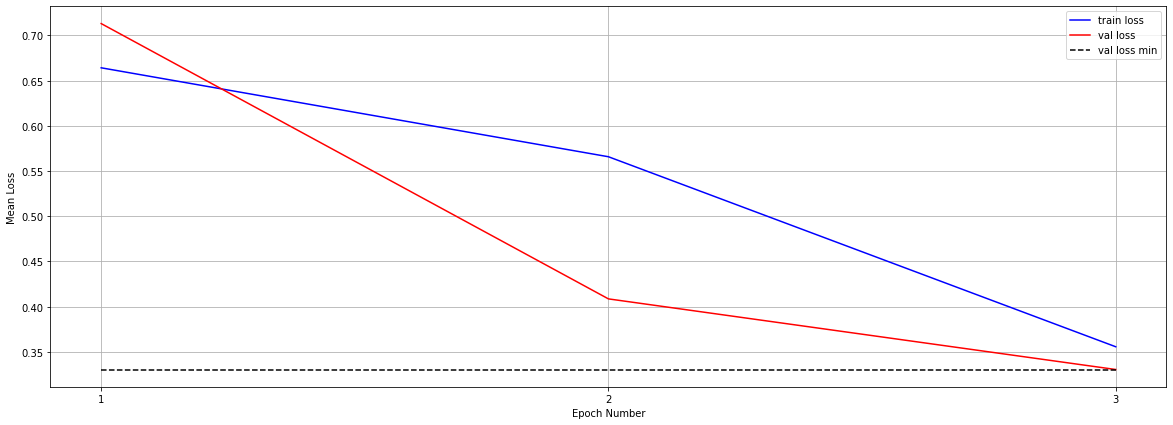

In [ ]:
utils.make_loss_plot(loss_history,val_loss_min,model_dir)

## Evaluate model

In [ ]:
results = {}

names = 'train val test'.split()

loaders = [train_loader,val_loader,test_loader]
num_batches = 10e3

val_loss = []
for name,loader in zip(names,loaders):
    results[name] = {}
    eval_loss = []
    batch_idx = 0
    num_correct = 0
    total = 0
    for inputs,lengths,labels in loader:
        if batch_idx < num_batches:
            model.eval()
            h = model.init_hidden()
            inputs, lengths, labels = inputs.to(device), lengths.to(device), labels.to(device)
            probs,h = model(inputs,lengths,h)
            loss = loss_function(probs, labels)
            label = labels[:,1]
            
            if is_cuda:
                pred = probs.argmax(axis=1).cpu().numpy()
                label = labels[:,1].cpu().numpy()
            else:
                pred = probs.argmax(axis=1).detach().numpy()
                label = labels[:,1].detach().numpy()

            correct = pred == label
            num_correct += correct.sum()
            total += label.shape[0]
            
            eval_loss.append(loss.item())

            batch_idx += 1

    mean_loss = round(np.mean(eval_loss),3)
    acc = round(num_correct*100/total,2)

    print(f'----{name} set----'.upper())
    print(f'{name} loss of {mean_loss}')
    print(f'{name} accuracy of {acc}')

    results[name]['mean_loss'] = mean_loss
    results[name]['acc'] = acc

utils.save_eval(model_version,results)


----TRAIN SET----
train loss of 0.315
train accuracy of 87.34
----VAL SET----
val loss of 0.33
val accuracy of 86.42
----TEST SET----
test loss of 0.324
test accuracy of 86.8


## Example predictions

In [ ]:
model_dir = '/content/drive/My Drive/colab_data/model_checkpoints/v14'
load_path = os.path.join(model_dir,'glove_lstm_batch.pt')
if is_cuda:
    model.load_state_dict(torch.load(load_path))
else:
    model.load_state_dict(torch.load(load_path,map_location=torch.device('cpu')))

In [ ]:
model_version = 'v16'
model_name = 'glove_lstm_batch.pt'
inf_model = utils.create_inference_model(model_version,model_name,glove,is_cuda,device)

In [ ]:
sentence = 'this movie sucks'.split()
utils.predict_from_inf_model(sentence, word2idx, inf_model, device, is_cuda, return_prob=True)

array([0.805287  , 0.19471297], dtype=float32)

## Start tensorboard

In [ ]:
log_dir

'/content/drive/My Drive/colab_data/model_checkpoints/v14/logs'

In [ ]:
%tensorboard --logdir '/content/drive/My Drive/colab_data/model_checkpoints/v14/logs'

## Optuna

In [ ]:
fields = 'model_version batch_size p_dropout num_layers num_epochs test_acc test_loss train_acc train_loss'.split()
csv_path = '/content/drive/My Drive/colab_data/optuna_search.csv'
#utils.init_csv(fields,csv_path)

In [ ]:
def objective(trial, glove, train_data, test_data, val_data, word2idx):
    num_labels = 2
    vocab_size = 100000
    embedding_dim = 300
    
    hidden = 100
    #p_dropout = .3
    #batch_size = 100
    #num_layers = 2

    loss_function = nn.BCELoss()

    lr = .001

    num_epochs = 30

    batch_size = trial.suggest_categorical('batch_size', [10, 100, 500])
    p_dropout = trial.suggest_uniform('p_dropout', 0, .5)
    num_layers = trial.suggest_int('num_layers', 1, 5)

    train_loader,test_loader,val_loader = utils.load_all_tensor_data(train_data, test_data, val_data, batch_size, word2idx)

    params = {}
    params['num_labels'] = num_labels
    params['vocab_size'] = vocab_size
    params['embedding_dim'] = embedding_dim
    params['num_layers'] = num_layers
    params['hidden'] = hidden
    params['batch_size'] = batch_size
    params['p_dropout'] = p_dropout
    params['lr'] = lr
    params['is_cuda'] = is_cuda
    params['device_name'] = device_name
    params['num_epochs'] = num_epochs

    model_version = utils.get_run_version()
    model_dir,log_dir = utils.setup_dir(model_version)

    utils.save_params(model_version,params)

    model = models.lstm_clf_batch(num_labels,vocab_size,embedding_dim,num_layers,hidden,batch_size,glove.vectors,device,p_dropout)
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    print(f'Training model {model_version}')
    loss_history,val_loss_min = utils.train_model(model_dir,params,train_loader,val_loader,model,model_version,device,is_cuda,loss_function)
    utils.make_loss_plot(loss_history,val_loss_min,model_dir)
    plt.close()
    model = utils.load_model_checkpoint(model_version,is_cuda,model)
    eval_results = utils.eval_model(train_loader,val_loader,test_loader,model,model_version,device,is_cuda,loss_function)

    num_layers = params['num_layers']
    num_epochs = params['num_epochs']
    batch_size = params['batch_size']

    train_acc = eval_results['train']['acc']
    train_loss = eval_results['train']['mean_loss']

    test_acc = eval_results['test']['acc']
    test_loss = eval_results['test']['mean_loss']

    fields = [model_version,hidden,p_dropout,num_layers,num_epochs,test_acc,test_loss,train_acc,train_loss]
    csv_path = '/content/drive/My Drive/colab_data/optuna_search.csv'
    utils.write_result_row(fields,csv_path)

    return test_loss

In [ ]:
test_loss

0.461

In [ ]:
study.get_trials()[0].params

{'batch_size': 10, 'num_layers': 5, 'p_dropout': 0.2931657388278597}

In [ ]:
#study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, glove, train_data, test_data, val_data, word2idx), n_trials=5)

Training model v77
45 seconds to train epoch
Epoch 1/30: train loss of 0.587, val loss of 0.496
Val loss decreased inf --> 0.496 saving model...
45 seconds to train epoch
Epoch 2/30: train loss of 0.452, val loss of 0.463
Val loss decreased 0.496 --> 0.463 saving model...
45 seconds to train epoch
Epoch 3/30: train loss of 0.402, val loss of 0.401
Val loss decreased 0.463 --> 0.401 saving model...
45 seconds to train epoch
Epoch 4/30: train loss of 0.400, val loss of 0.457
45 seconds to train epoch
Epoch 5/30: train loss of 0.360, val loss of 0.359
Val loss decreased 0.401 --> 0.359 saving model...
45 seconds to train epoch
Epoch 6/30: train loss of 0.329, val loss of 0.332
Val loss decreased 0.359 --> 0.332 saving model...
45 seconds to train epoch
Epoch 7/30: train loss of 0.316, val loss of 0.318
Val loss decreased 0.332 --> 0.318 saving model...
45 seconds to train epoch
Epoch 8/30: train loss of 0.469, val loss of 0.492
45 seconds to train epoch
Epoch 9/30: train loss of 0.655, va

[I 2020-07-13 09:39:18,451] Finished trial#15 with value: 0.305 with parameters: {'batch_size': 500, 'p_dropout': 0.03412793834209135, 'num_layers': 2}. Best is trial#13 with value: 0.24.


Training model v78
34 seconds to train epoch
Epoch 1/30: train loss of 0.597, val loss of 0.588
Val loss decreased inf --> 0.588 saving model...
34 seconds to train epoch
Epoch 2/30: train loss of 0.509, val loss of 0.629
34 seconds to train epoch
Epoch 3/30: train loss of 0.398, val loss of 0.350
Val loss decreased 0.588 --> 0.350 saving model...
34 seconds to train epoch
Epoch 4/30: train loss of 0.348, val loss of 0.336
Val loss decreased 0.350 --> 0.336 saving model...
34 seconds to train epoch
Epoch 5/30: train loss of 0.317, val loss of 0.320
Val loss decreased 0.336 --> 0.320 saving model...
34 seconds to train epoch
Epoch 6/30: train loss of 0.299, val loss of 0.288
Val loss decreased 0.320 --> 0.288 saving model...
34 seconds to train epoch
Epoch 7/30: train loss of 0.298, val loss of 0.312
34 seconds to train epoch
Epoch 8/30: train loss of 0.292, val loss of 0.274
Val loss decreased 0.288 --> 0.274 saving model...
34 seconds to train epoch
Epoch 9/30: train loss of 0.274, va

[I 2020-07-13 09:50:59,212] Finished trial#16 with value: 0.225 with parameters: {'batch_size': 100, 'p_dropout': 0.14066773980033817, 'num_layers': 3}. Best is trial#16 with value: 0.225.


Training model v79
40 seconds to train epoch
Epoch 1/30: train loss of 0.682, val loss of 0.693
Val loss decreased inf --> 0.693 saving model...
40 seconds to train epoch
Epoch 2/30: train loss of 0.691, val loss of 0.689
Val loss decreased 0.693 --> 0.689 saving model...
40 seconds to train epoch
Epoch 3/30: train loss of 0.687, val loss of 0.692
40 seconds to train epoch
Epoch 4/30: train loss of 0.611, val loss of 0.373
Val loss decreased 0.689 --> 0.373 saving model...
41 seconds to train epoch
Epoch 5/30: train loss of 0.320, val loss of 0.289
Val loss decreased 0.373 --> 0.289 saving model...
40 seconds to train epoch
Epoch 6/30: train loss of 0.279, val loss of 0.264
Val loss decreased 0.289 --> 0.264 saving model...
40 seconds to train epoch
Epoch 7/30: train loss of 0.253, val loss of 0.259
Val loss decreased 0.264 --> 0.259 saving model...
41 seconds to train epoch
Epoch 8/30: train loss of 0.230, val loss of 0.250
Val loss decreased 0.259 --> 0.250 saving model...
40 seconds

[I 2020-07-13 10:01:17,649] Finished trial#17 with value: 0.25 with parameters: {'batch_size': 100, 'p_dropout': 0.14236026977284078, 'num_layers': 4}. Best is trial#16 with value: 0.225.


Training model v80
40 seconds to train epoch
Epoch 1/30: train loss of 0.554, val loss of 0.599
Val loss decreased inf --> 0.599 saving model...
40 seconds to train epoch
Epoch 2/30: train loss of 0.504, val loss of 0.479
Val loss decreased 0.599 --> 0.479 saving model...
41 seconds to train epoch
Epoch 3/30: train loss of 0.424, val loss of 0.383
Val loss decreased 0.479 --> 0.383 saving model...
41 seconds to train epoch
Epoch 4/30: train loss of 0.354, val loss of 0.337
Val loss decreased 0.383 --> 0.337 saving model...
40 seconds to train epoch
Epoch 5/30: train loss of 0.350, val loss of 0.305
Val loss decreased 0.337 --> 0.305 saving model...
41 seconds to train epoch
Epoch 6/30: train loss of 0.290, val loss of 0.266
Val loss decreased 0.305 --> 0.266 saving model...
41 seconds to train epoch
Epoch 7/30: train loss of 0.259, val loss of 0.265
Val loss decreased 0.266 --> 0.265 saving model...
41 seconds to train epoch
Epoch 8/30: train loss of 0.243, val loss of 0.247
Val loss d

[I 2020-07-13 10:11:38,152] Finished trial#18 with value: 0.24 with parameters: {'batch_size': 100, 'p_dropout': 0.07527210359037816, 'num_layers': 4}. Best is trial#16 with value: 0.225.


Training model v81
40 seconds to train epoch
Epoch 1/30: train loss of 0.571, val loss of 0.597
Val loss decreased inf --> 0.597 saving model...
41 seconds to train epoch
Epoch 2/30: train loss of 0.555, val loss of 0.479
Val loss decreased 0.597 --> 0.479 saving model...
41 seconds to train epoch
Epoch 3/30: train loss of 0.470, val loss of 0.400
Val loss decreased 0.479 --> 0.400 saving model...
40 seconds to train epoch
Epoch 4/30: train loss of 0.386, val loss of 0.350
Val loss decreased 0.400 --> 0.350 saving model...
41 seconds to train epoch
Epoch 5/30: train loss of 0.337, val loss of 0.318
Val loss decreased 0.350 --> 0.318 saving model...
41 seconds to train epoch
Epoch 6/30: train loss of 0.303, val loss of 0.282
Val loss decreased 0.318 --> 0.282 saving model...
40 seconds to train epoch
Epoch 7/30: train loss of 0.281, val loss of 0.272
Val loss decreased 0.282 --> 0.272 saving model...
41 seconds to train epoch
Epoch 8/30: train loss of 0.301, val loss of 0.279
41 seconds

[I 2020-07-13 10:24:16,355] Finished trial#19 with value: 0.234 with parameters: {'batch_size': 100, 'p_dropout': 0.07082338453692434, 'num_layers': 4}. Best is trial#16 with value: 0.225.


In [ ]:
best_trial = study.best_trial
print(f'Metric: {best_trial.value}')
print(f'Best hyperparameters: {best_trial.params}')

Metric: 0.225
Best hyperparameters: {'batch_size': 100, 'p_dropout': 0.14066773980033817, 'num_layers': 3}


In [ ]:
df = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

In [ ]:
df

,number,value,params_batch_size,params_num_layers,params_p_dropout,state
0,0,0.693,10,5,0.293166,COMPLETE
1,1,0.252,100,1,0.091056,COMPLETE
2,2,0.607,100,5,0.325204,COMPLETE
3,3,0.242,10,1,0.043296,COMPLETE
4,4,0.412,500,1,0.488119,COMPLETE
5,5,0.384,500,2,0.033961,COMPLETE
6,6,0.246,100,3,0.202583,COMPLETE
7,7,0.245,10,1,0.011884,COMPLETE
8,8,0.242,100,2,0.212602,COMPLETE
9,9,0.248,10,3,0.248215,COMPLETE


In [ ]:
study_dir = '/content/drive/My Drive/colab_data/optuna_studies/study_v2.pkl'
joblib.dump(study,study_dir)

['/content/drive/My Drive/colab_data/optuna_studies/study_v2.pkl']

In [ ]:
study = joblib.load(study_dir)

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)